# Data Science - Laboratorio 6
## Minería de Texto: Análisis de Sentimientos
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -
## Ejercicio 1 - Disaster Tweets

## Librerias

NOTA: Importante tener el Token de la API en el folder "C:\Users\<Windows-username>\.kaggle\kaggle.json"

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [55]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones con archivos
import os
import zipfile

# Operaciones con datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de lengauje natural
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Modelado y evaluación
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Utilidades
from collections import Counter

## Carga de Dataset

### Descargar el archivo con Kaggle

Puede omitir esta celda si decide descargar los archivos manualmente desde https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews

In [56]:
# Autenticación con Kaggle API
kaggle.api.authenticate()

# Definir dataset y directorio de descarga
dataset_name = 'datafiniti/grammar-and-online-product-reviews'
target_path = 'data'

# Nombre del archivo que deseas descargar
file_name = 'GrammarandProductReviews.csv'

# Verificar si el archivo ya existe en el directorio de descarga
if not os.path.exists(f"{target_path}/{file_name}"):
    # Descargar archivo específico desde el dataset
    try:
        kaggle.api.dataset_download_file(dataset=dataset_name,
                                         file_name=file_name,
                                         path=target_path,
                                         quiet=False)
        print(f"EXITO: {file_name} descargado en '{target_path}'")
    except ApiException as e:
        print(f"ERROR al llamar KaggleApi -> dataset_download_file \n\t{e}")
else:
    print(f"AVISO: El archivo '{file_name}' ya existe en el directorio '{target_path}'")


AVISO: El archivo 'GrammarandProductReviews.csv' ya existe en el directorio 'data'


### Descomprimir el Zip

Puede omitir esta celda si ya tiene los archivos descomprimidos

In [57]:
import os
import zipfile

# Definir el dataset y la ruta de destino
dataset_name = 'datafiniti/grammar-and-online-product-reviews'
target_path = 'data'
file_name = 'GrammarandProductReviews.csv'

# Verificar si ya se descomprimieron los archivos .zip previamente
if os.path.exists(f"{target_path}/{file_name}"):
    print("AVISO: Se encontraron archivos descargados previamente")
    print("\tOmitiendo descompresión de archivos .zip")

# Descomprimir archivo .zip
else:
    try:
        # Verificar si se descargó un archivo .zip y descomprimirlo
        zip_file_path = f"{target_path}/{file_name}.zip"
        
        if os.path.exists(zip_file_path):
            # Descomprimir archivo .zip
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(target_path)
            
            # Eliminar archivo .zip
            os.remove(zip_file_path)
            print(f"EXITO: Archivo .zip descomprimido en '{target_path}'")
        else:
            raise Exception(f"No se encontró archivo .zip en '{target_path}'")

    except Exception as e:
        print(f"ERROR al descomprimir archivo .zip \n\t{e}")


AVISO: Se encontraron archivos descargados previamente
	Omitiendo descompresión de archivos .zip


### Generar dataframes

In [58]:
# Cargar archivos en DataFrames
train_df = pd.read_csv('data/GrammarandProductReviews.csv')

## Comprensión Inicial

### Información General del Dataset

In [59]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas    
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        'Valores Únicos': df.nunique(),
        'Valores Duplicados': df.duplicated().sum()
    }).reset_index(drop=True)

    # Mostrar la informacion
    print(f"\nEl dataframe tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [60]:
print(f"Informacion del dataset: GrammarandProductReviews.csv")
get_DF_info(df=train_df)

Informacion del dataset: GrammarandProductReviews.csv

El dataframe tiene 71044 filas (registros) y 25 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,id,object,0.00,600,0
1,brand,object,0.00,392,0
2,categories,object,0.00,581,0
3,dateAdded,object,0.00,598,0
4,dateUpdated,object,0.00,354,0
5,ean,object,45.01,473,0
6,keys,object,0.00,600,0
7,manufacturer,object,0.20,463,0
8,manufacturerNumber,object,0.29,583,0
9,name,object,0.00,600,0


Como era de esperarse la variable `id` tiene un valor diferente por cada registro, por lo tanto no es relevante para esta práctica.

El conjunto de datos tiene 13 variables que presentan valores nulos:
Las cuales son: 
1. ean
2. manufacturer
3. manufacturerNumber
4. reviews.date
5. reviews.didPurschase
6. reviews.doRecommend
7. reviews.id
8. reviews.numHelpful
9. reviews.text
10. reviews.title
11. reviews.userCity
12. reviews.userProvince
13. reviews.username

De las variables que más llaman la atención tenemos: ean, reviews.didPurschase, reviews.doRecommend, reviews.id, reviews.numHelpful, reviews.userCity y reviews.userProvince. Esto porque son variables que tienen más del 14% de valores nulos.

- `ean`: Tiene un **45.01%** de los registros totales nulos.
- `reviews.didPurschase`: Tiene un **54.74%** de los registros totales nulos.
- `reviews.doRecommend`: Tiene un **14.94%** de los registros totales nulos.
- `reviews.id`: Tiene un **54.74%** de los registros totales nulos.
- `reviews.numHelpful`: Tiene un **54.24%** de los registros totales nulos.
- `reviews.userCity`: Tiene un **92.39%** de los registros totales nulos.
- `reviews.userProvince`: Tiene un **99.37%** de los registros totales nulos.

Por lo tanto sera necesario analizar con detenimiento como manejar estas variables.

In [61]:
# Contar la cantidad de celdas no nulas en todo el dataset
total_celdas = train_df.shape[0] * train_df.shape[1]  # Total de celdas (filas * columnas)
celdas_no_nulas = train_df.count().sum()  # Suma de todas las celdas no nulas
celdas_nulas = total_celdas - celdas_no_nulas  # Número de celdas nulas

print(f"Total de celdas: {total_celdas:,}")
print(f"Celdas no nulas: {celdas_no_nulas:,}")
print(f"Celdas nulas: {celdas_nulas:,}")

# Opción adicional: mostrar el número de celdas no nulas por cada columna
print("\nCeldas no nulas por columna:")
print(train_df.count())

Total de celdas: 1,776,100
Celdas no nulas: 1,479,941
Celdas nulas: 296,159

Celdas no nulas por columna:
id                      71044
brand                   71044
categories              71044
dateAdded               71044
dateUpdated             71044
ean                     39065
keys                    71044
manufacturer            70903
manufacturerNumber      70841
name                    71044
reviews.date            70977
reviews.dateAdded       71044
reviews.dateSeen        71044
reviews.didPurchase     32158
reviews.doRecommend     60429
reviews.id              32158
reviews.numHelpful      32508
reviews.rating          71044
reviews.sourceURLs      71044
reviews.text            71008
reviews.title           70567
reviews.userCity         5410
reviews.userProvince      449
reviews.username        70942
upc                     71042
dtype: int64


### Visualizar Dataframe

In [62]:
train_df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


## Preprocesamiento y Limpieza

### Valores Nulos

#### Verificación valores nulos

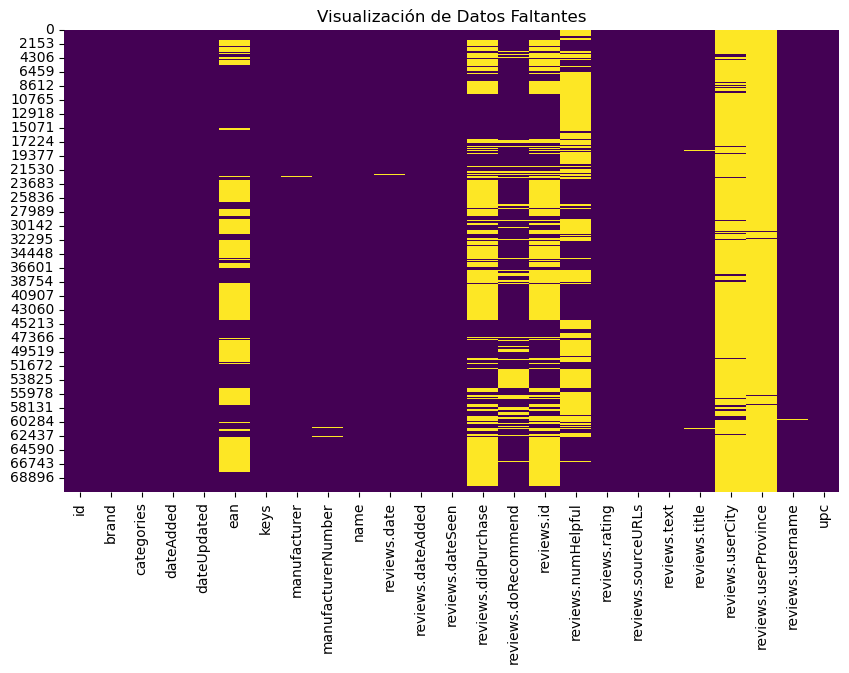

In [63]:
# Visualización de los datos faltantes en el conjunto de entrenamiento
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualización de Datos Faltantes")
plt.show()

#### Análisis de Impacto de Nulos

In [64]:
columns_to_check = [
    'ean', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.didPurchase',
    'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.text',
    'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username'
]

# Total de registros inicial
initial_count = train_df.shape[0]

# Inicialización de contadores de registros y porcentajes
counts_after_dropna = []
percentages_after_dropna = []

# Análisis por columna (eliminando nulos de una columna a la vez)
for column in columns_to_check:
    dropna_column = train_df.dropna(subset=[column])
    dropna_column_count = dropna_column.shape[0]
    dropna_column_pct = (dropna_column_count / initial_count) * 100
    
    # Guardar el conteo y el porcentaje conservado para cada columna
    counts_after_dropna.append(dropna_column_count)
    percentages_after_dropna.append(dropna_column_pct)

# Análisis eliminando todos los nulos (en cualquier columna)
dropna_all = train_df.dropna(subset=columns_to_check)
dropna_all_count = dropna_all.shape[0]
dropna_all_pct = (dropna_all_count / initial_count) * 100

# Resultados del análisis: agregamos la columna original con 100%
counts_after_dropna.insert(0, initial_count)
percentages_after_dropna.insert(0, 100)

# Lista de variables y sus resultados
escenarios = ['Original'] + [f'Sin {col}' for col in columns_to_check] 
conteos = counts_after_dropna

# Crear un DataFrame con los resultados
simplified_impact_analysis = pd.DataFrame({
    'Escenario': escenarios,
    'Conteo': conteos,
    'Porcentaje conservado (%)': percentages_after_dropna
})

# Mostrar los resultados formateados
print(simplified_impact_analysis.to_string(index=False, justify='left'))


Escenario                 Conteo  Porcentaje conservado (%)
                Original 71044   100.000000                
                 Sin ean 39065    54.987050                
        Sin manufacturer 70903    99.801531                
  Sin manufacturerNumber 70841    99.714262                
        Sin reviews.date 70977    99.905692                
 Sin reviews.didPurchase 32158    45.264906                
 Sin reviews.doRecommend 60429    85.058555                
          Sin reviews.id 32158    45.264906                
  Sin reviews.numHelpful 32508    45.757559                
        Sin reviews.text 71008    99.949327                
       Sin reviews.title 70567    99.328585                
    Sin reviews.userCity  5410     7.614999                
Sin reviews.userProvince   449     0.632003                
    Sin reviews.username 70942    99.856427                


Estos resultados muestran que eliminar los registros nulos tiene un impacto significativo en el tamaño del conjunto de datos. Al eliminar ciertos datos nulos tenemos que en el mejor de los casos podremos llegar a conservar el 99.9% de los datos y en el peor de los casos tenemos que nos quedaría un total de 0.6%.

Por lo que se van a eliminar los datos nulos en las variables que representen un mínimo y eliminar la variable como tal en el resto.

#### Manejo de Nulos

In [65]:
# Lista de columnas a eliminar
columns_to_drop = ['ean', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
                   'reviews.numHelpful', 'reviews.userCity', 'reviews.userProvince']

# Eliminar columnas si existen
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True)

# Lista de columnas para eliminar registros nulos
columns_to_check_for_na = ['manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.title', 'reviews.username']

# Eliminar registros con nulos en las columnas que existen
train_df.dropna(subset=[col for col in columns_to_check_for_na if col in train_df.columns], inplace=True)

# Verificar si se eliminaron los registros con valores nulos
print("Datos faltantes en el conjunto de entrenamiento:")
print(train_df.isnull().sum())


Datos faltantes en el conjunto de entrenamiento:
id                     0
brand                  0
categories             0
dateAdded              0
dateUpdated            0
keys                   0
manufacturer           0
manufacturerNumber     0
name                   0
reviews.date           0
reviews.dateAdded      0
reviews.dateSeen       0
reviews.rating         0
reviews.sourceURLs     0
reviews.text          23
reviews.title          0
reviews.username       0
upc                    0
dtype: int64


### Limpieza y Normalización de Texto

**Paso 1: Limpieza del Texto**
- Eliminar URLs: Los URLs no aportan valor en el contexto del análisis de texto para la clasificación de desastres.
- Eliminar caracteres especiales: Se eliminaran caracteres como #, @, y otros que no aportan semántica al contenido del texto.
- Eliminar emoticones: Similarmente, los emoticones no son relevantes para este análisis.

**Paso 2: Normalización del Texto**
- Convertir a minúsculas: Para evitar tratar palabras como diferentes si solo varían en el uso de mayúsculas o minúsculas.

**Paso 3: Eliminación de Palabras Vacías (Stopwords)**
- Eliminar palabras comunes: Palabras como `el`, `la`, `de`, `y`, etc., que no aportan valor en la clasificación.
- Eliminar terminos usados en twitter: como `RT`

**Paso 4: Conversión de palabras a su forma mas general (Stemming)**
- Stemming: Se obtiene la raiz de las palabras para que pasen a su forma mas general, esto para poder reducir significativamente el tamaño del vocabulario.

In [66]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Descargar las stopwords
nltk.download('stopwords')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Inicializar el stemmer
stemmer = PorterStemmer()

# Función para limpiar el texto
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales, números, emoticones
    text = re.sub(r'\@\w+|\#|\d+|[^\w\s]', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Aplicar stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Verificar que la columna 'reviews.text' existe
print(train_df.columns)

# Aplicar la limpieza de texto en la columna 'reviews.text', omitiendo valores nulos
train_df['clean_text'] = train_df['reviews.text'].dropna().apply(clean_text)

# Ver las primeras filas del dataset después de la limpieza
print(train_df[['reviews.text', 'clean_text']].head())


Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'upc'],
      dtype='object')


[nltk_data] Downloading package stopwords to C:\Users\Pablo
[nltk_data]     Orellana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        reviews.text  \
0  i love this album. it's very good. more to the...   
1  Good flavor. This review was collected as part...   
2                                       Good flavor.   
3  I read through the reviews on here before look...   
4  My husband bought this gel for us. The gel cau...   

                                          clean_text  
0  love album good hip hop side current pop sound...  
1             good flavor review collect part promot  
2                                        good flavor  
3  read review look buy one coupl lubric ultim di...  
4  husband bought gel us gel caus irrit felt like...  


## Análisis de Frecuencias de Palabras

### Conteo de palabras

In [73]:
train_df = train_df[train_df['reviews.rating'].notna() & train_df['clean_text'].notna()]

# Separar las reseñas en tres grupos basados en 'reviews.rating'
negative_reviews = train_df[train_df['reviews.rating'] <= 2]['clean_text']
positive_reviews = train_df[train_df['reviews.rating'] >= 4]['clean_text']
neutral_reviews = train_df[(train_df['reviews.rating'] > 2) & (train_df['reviews.rating'] < 4)]['clean_text']

# Contar la frecuencia de palabras en cada grupo
negative_words = Counter(" ".join(negative_reviews).split())
positive_words = Counter(" ".join(positive_reviews).split())
neutral_words = Counter(" ".join(neutral_reviews).split())

# Obtener las 10 palabras más comunes en cada grupo
common_negative_words = negative_words.most_common(10)
common_positive_words = positive_words.most_common(10)
common_neutral_words = neutral_words.most_common(10)

# Mostrar las palabras más comunes en cada grupo
print("Palabras más comunes en reseñas negativas:")
for i, (word, count) in enumerate(common_negative_words):
    print(f"Palabra {i+1}: '{word}' con frecuencia {count}")

print("\n", "-"*50)

print("Palabras más comunes en reseñas positivas:")
for i, (word, count) in enumerate(common_positive_words):
    print(f"Palabra {i+1}: '{word}' con frecuencia {count}")

print("\n", "-"*50)

print("Palabras más comunes en reseñas neutras:")
for i, (word, count) in enumerate(common_neutral_words):
    print(f"Palabra {i+1}: '{word}' con frecuencia {count}")

Palabras más comunes en reseñas negativas:
Palabra 1: 'use' con frecuencia 3899
Palabra 2: 'product' con frecuencia 3280
Palabra 3: 'like' con frecuencia 1627
Palabra 4: 'one' con frecuencia 1613
Palabra 5: 'new' con frecuencia 1519
Palabra 6: 'work' con frecuencia 1391
Palabra 7: 'would' con frecuencia 1330
Palabra 8: 'mop' con frecuencia 1321
Palabra 9: 'formula' con frecuencia 1285
Palabra 10: 'hair' con frecuencia 1232

 --------------------------------------------------
Palabras más comunes en reseñas positivas:
Palabra 1: 'use' con frecuencia 24943
Palabra 2: 'love' con frecuencia 20559
Palabra 3: 'movi' con frecuencia 19724
Palabra 4: 'product' con frecuencia 19517
Palabra 5: 'great' con frecuencia 19152
Palabra 6: 'review' con frecuencia 17487
Palabra 7: 'part' con frecuencia 17139
Palabra 8: 'collect' con frecuencia 17026
Palabra 9: 'promot' con frecuencia 16210
Palabra 10: 'clean' con frecuencia 11169

 --------------------------------------------------
Palabras más comunes e